In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('../data/cleaned_train_with_amenities.csv', dtype={'postal_code': str})
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162691 entries, 0 to 162690
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   town                         162691 non-null  object 
 1   flat_type                    162691 non-null  object 
 2   block                        162691 non-null  object 
 3   street                       162691 non-null  object 
 4   floor_area_sqm               162691 non-null  float64
 5   flat_model                   162691 non-null  object 
 6   lease_commence_data          162691 non-null  int64  
 7   resale_price                 162691 non-null  float64
 8   postal_code                  162691 non-null  object 
 9   latitude                     162691 non-null  float64
 10  longitude                    162691 non-null  float64
 11  max_floor                    162691 non-null  int64  
 12  subzone                      162691 non-null  object 
 13 

# Preprocessing pipeline for CatBoost and Ridge Regression

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162691 entries, 0 to 162690
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   town                         162691 non-null  object 
 1   flat_type                    162691 non-null  object 
 2   block                        162691 non-null  object 
 3   street                       162691 non-null  object 
 4   floor_area_sqm               162691 non-null  float64
 5   flat_model                   162691 non-null  object 
 6   lease_commence_data          162691 non-null  int64  
 7   resale_price                 162691 non-null  float64
 8   postal_code                  162691 non-null  object 
 9   latitude                     162691 non-null  float64
 10  longitude                    162691 non-null  float64
 11  max_floor                    162691 non-null  int64  
 12  subzone                      162691 non-null  object 
 13 

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge

In [5]:
# CatBoost preprocessing pipeline

cat_features = ['town', 'flat_type', 'flat_model', 'nearest_mrt',
                'nearest_primary_school', 'nearest_secondary_school',
                'nearest_mall', 'nearest_hawker']

catboost_pipeline = Pipeline([
    ("catboost", CatBoostRegressor(
        cat_features=cat_features,
        depth=8,
        learning_rate=0.1,
        iterations=1000,
        verbose=200
    ))
])

In [7]:
numeric_df = train_df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()
price_corr = corr_matrix['resale_price'].sort_values(ascending=False)

print(price_corr)

resale_price                   1.000000
resale_price_per_sqm           0.703378
flat_type_num                  0.589706
floor_area_sqm                 0.578110
flat_model_num                 0.501302
max_floor                      0.460855
index                          0.400479
month_from2017                 0.383389
lease_commence_data            0.368591
height                         0.342613
near_mall_count                0.206772
near_hawker_count              0.173085
near_mrt_count                 0.167042
longitude                      0.097484
mrt_distance                   0.068702
near_secondary_school_count    0.063205
mrt_status                     0.041864
mall_distance                  0.036132
near_primary_school_count      0.028052
primary_school_distance       -0.003376
hawker_distance               -0.017922
secondary_school_distance     -0.063882
latitude                      -0.170889
age_at_sale                   -0.305935
Name: resale_price, dtype: float64


In [8]:
# include features with positive correlations

ridge_num_features = ['flat_type_num', 'floor_area_sqm', 'flat_model_num', 
                      'max_floor', 'month_from2017', 'lease_commence_data',
                      'height', 'near_mall_count', 'near_hawker_count',
                      'near_mrt_count', 'longitude', 'mrt_distance', 
                      'near_secondary_school_count', 'mrt_status', 'mall_distance',
                      'near_primary_school_count']

ridge_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ridge_num_features)
])

ridge_pipeline = Pipeline([
    ("preprocessor", ridge_preprocessor),
    ("model", Ridge(alpha=1.0))
])

In [9]:
from sklearn.ensemble import StackingRegressor

stacked_model = StackingRegressor(
    estimators=[
        ('catboost', catboost_pipeline),
        ('ridge', ridge_pipeline)
    ],
    final_estimator=Ridge(alpha=0.5),
    cv=3,
    n_jobs=-1
)

In [14]:
# Drop granular features
train_df.drop(columns=['block','street','postal_code','subzone'], inplace=True)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162691 entries, 0 to 162690
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   town                         162691 non-null  object 
 1   flat_type                    162691 non-null  object 
 2   floor_area_sqm               162691 non-null  float64
 3   flat_model                   162691 non-null  object 
 4   lease_commence_data          162691 non-null  int64  
 5   resale_price                 162691 non-null  float64
 6   latitude                     162691 non-null  float64
 7   longitude                    162691 non-null  float64
 8   max_floor                    162691 non-null  int64  
 9   height                       162691 non-null  int64  
 10  month_from2017               162691 non-null  int64  
 11  age_at_sale                  162691 non-null  int64  
 12  index                        162691 non-null  float64
 13 

In [16]:
# Split the data into features and target variable
X = train_df.drop(columns=['resale_price','resale_price_per_sqm'])
y = train_df['resale_price']
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    # CatBoost parameters (inside its pipeline)
    'catboost__catboost__depth': [6, 8, 10],
    'catboost__catboost__learning_rate': [0.05, 0.1, 0.2],
    'catboost__catboost__iterations': [500, 1000],
    
    # Ridge base model alpha
    'ridge__model__alpha': [0.1, 1.0, 10.0],
    
    # Meta-model (stacking final estimator)
    'final_estimator__alpha': [0.1, 0.5, 1.0]
}

search = RandomizedSearchCV(
    estimator=stacked_model,   # directly pass the StackingRegressor
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


0:	learn: 170309.8972695	total: 225ms	remaining: 3m 44s
0:	learn: 169975.3698635	total: 221ms	remaining: 3m 40s
0:	learn: 169692.1132083	total: 244ms	remaining: 4m 3s
0:	learn: 169525.4313057	total: 270ms	remaining: 4m 30s
0:	learn: 170308.8706318	total: 242ms	remaining: 4m 1s
0:	learn: 176417.7208702	total: 336ms	remaining: 2m 47s
0:	learn: 175590.0755745	total: 390ms	remaining: 3m 14s
0:	learn: 175778.2995383	total: 355ms	remaining: 2m 57s
0:	learn: 176056.7652792	total: 447ms	remaining: 3m 42s
0:	learn: 176394.7360920	total: 381ms	remaining: 3m 10s
0:	learn: 175395.1956001	total: 401ms	remaining: 6m 40s
0:	learn: 176176.5650424	total: 537ms	remaining: 8m 56s
200:	learn: 32260.5522664	total: 32.2s	remaining: 2m 7s
200:	learn: 32307.6399491	total: 32.4s	remaining: 2m 8s
200:	learn: 32273.8843986	total: 32.6s	remaining: 2m 9s
200:	learn: 32236.6253273	total: 32.8s	remaining: 2m 10s
200:	learn: 32226.9594868	total: 33.1s	remaining: 2m 11s
200:	learn: 33412.5203691	total: 42.9s	remaining

,estimator,"StackingRegre...5), n_jobs=-1)"
,param_distributions,"{'catboost__catboost__depth': [6, 8, ...], 'catboost__catboost__iterations': [500, 1000], 'catboost__catboost__learning_rate': [0.05, 0.1, ...], 'final_estimator__alpha': [0.1, 0.5, ...], ...}"
,n_iter,20
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [18]:
best_model = search.best_estimator_
print("Best parameters:", search.best_params_)

Best parameters: {'ridge__model__alpha': 1.0, 'final_estimator__alpha': 0.1, 'catboost__catboost__learning_rate': 0.1, 'catboost__catboost__iterations': 1000, 'catboost__catboost__depth': 10}


In [19]:
val_pred = best_model.predict(X_val)
print("Validation R²:", best_model.score(X_val, y_val))

rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print("Validation RMSE:", rmse)

Validation R²: 0.9816011014295403
Validation RMSE: 24775.487752064215


# Ensemble Feature Analysis

                        feature  importance
2                floor_area_sqm   15.480138
11                        index   11.580527
1                     flat_type   11.038190
4           lease_commence_data    9.775924
25            near_hawker_count    8.842439
9                month_from2017    6.592745
24               flat_model_num    4.976868
0                          town    4.134838
7                     max_floor    3.444342
8                        height    3.206186
13                 mrt_distance    2.642456
23                flat_type_num    2.174399
10                  age_at_sale    2.143215
6                     longitude    1.743929
20                mall_distance    1.613773
19                 nearest_mall    1.322533
26               near_mrt_count    1.296529
3                    flat_model    1.046005
14                   mrt_status    1.025273
17     nearest_secondary_school    0.944565
5                      latitude    0.850701
29              near_mall_count 

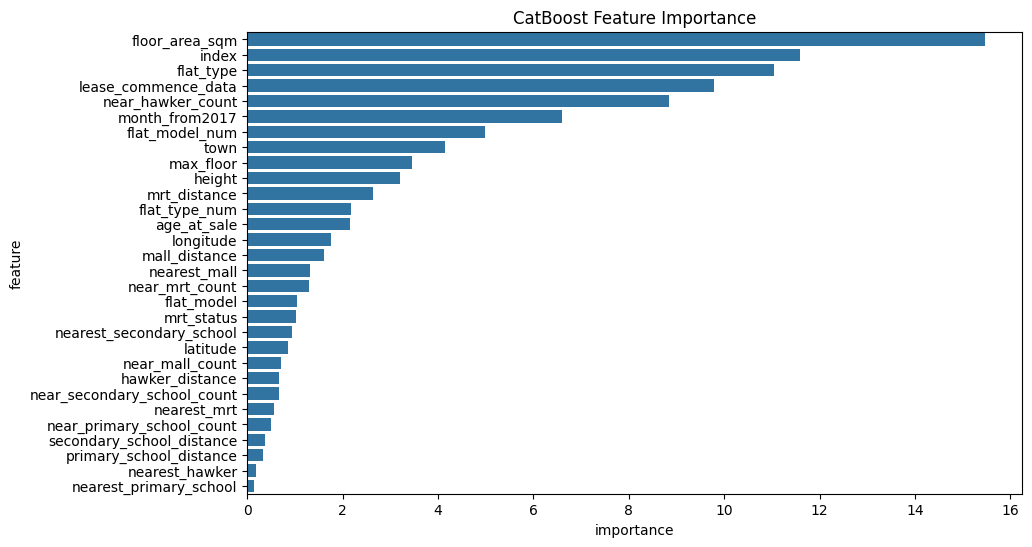

In [20]:
catboost_model = best_model.named_estimators_['catboost'].named_steps['catboost']

# Feature importance by gain
importances = catboost_model.get_feature_importance(type='FeatureImportance')
features = catboost_model.feature_names_
catboost_feat_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)
print(catboost_feat_df)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=catboost_feat_df)
plt.title("CatBoost Feature Importance")
plt.show()


In [21]:
ridge_model = best_model.named_estimators_['ridge'].named_steps['model']
ridge_features = ridge_num_features  # numeric features you passed to Ridge
ridge_coefs = ridge_model.coef_

ridge_feat_df = pd.DataFrame({'feature': ridge_features, 'coefficient': ridge_coefs}).sort_values(by='coefficient', key=abs, ascending=False)
print(ridge_feat_df)


                        feature    coefficient
1                floor_area_sqm  104988.401243
8             near_hawker_count   82200.710631
4                month_from2017   68791.100687
5           lease_commence_data   55685.217248
7               near_mall_count  -28679.886534
10                    longitude   26761.591947
3                     max_floor   24278.753516
6                        height   24217.980283
9                near_mrt_count   20826.556997
12  near_secondary_school_count  -15850.202961
2                flat_model_num   13146.315209
15    near_primary_school_count  -10703.320455
11                 mrt_distance   10378.837727
0                 flat_type_num    8796.041237
13                   mrt_status    8649.182286
14                mall_distance    2834.799053


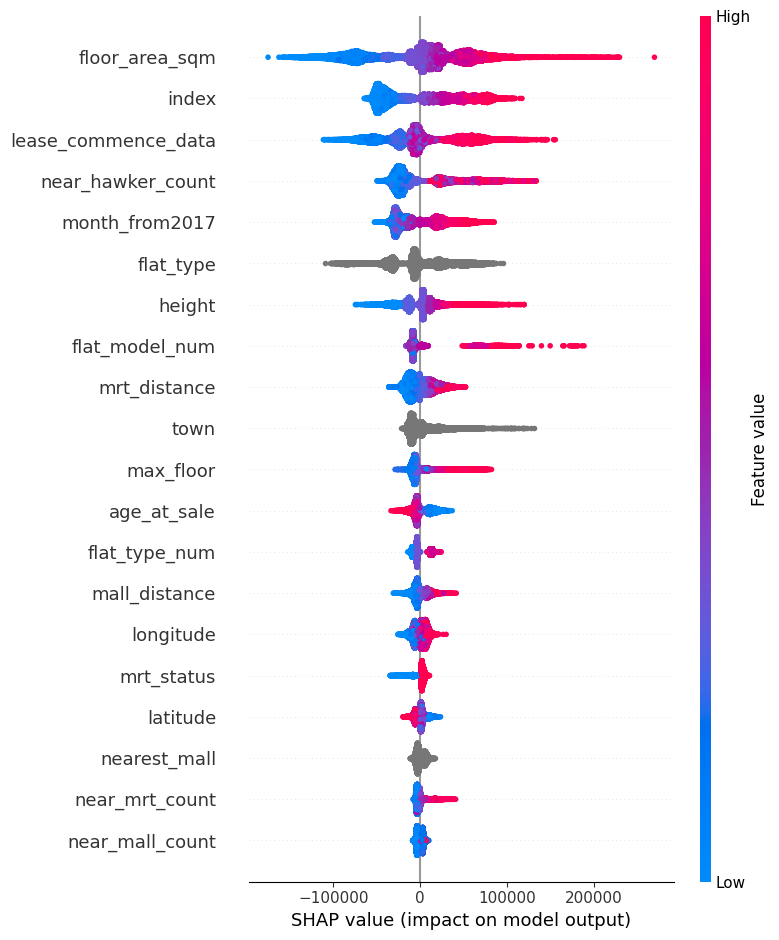

In [22]:
import shap

# Use CatBoost for SHAP (trees are faster)
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_val)

# Summary plot
shap.summary_plot(shap_values, X_val)

In [23]:
y_pred_cat = catboost_model.predict(X_val)
y_pred_ens = best_model.predict(X_val)

print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_cat)))
print("Ensemble RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_ens)))

CatBoost RMSE: 24776.251297504477
Ensemble RMSE: 24775.487752064215
